<a href="https://colab.research.google.com/github/kridtapon/Stoch-Klinger-Momentum-Strategy/blob/main/Stoch_Klinger_Momentum_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.54
    Uninstalling yfinance-0.2.54:
      Successfully uninstalled yfinance-0.2.54


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Stochastic RSI
def calculate_stochastic_rsi(df, period=14, smooth_period=3):
    """
    Calculate the Stochastic RSI (StochRSI).
    """
    rsi = df['Close'].rolling(window=period).apply(lambda x: 100 * (x[-1] - min(x)) / (max(x) - min(x)))
    stoch_rsi = (rsi - rsi.rolling(window=period).min()) / (rsi.rolling(window=period).max() - rsi.rolling(window=period).min())
    stoch_rsi_smooth = stoch_rsi.rolling(window=smooth_period).mean()
    return stoch_rsi, stoch_rsi_smooth

# Function to calculate Klinger Oscillator
def calculate_klinger_oscillator(df, short_period=34, long_period=55, signal_period=13):
    """
    Calculate the Klinger Oscillator.
    """
    # Calculate Money Flow Multiplier and Money Flow Volume
    mfm = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfm * df['Volume']

    # Short-term and long-term EMAs
    short_ema = mfv.ewm(span=short_period).mean()
    long_ema = mfv.ewm(span=long_period).mean()

    # Klinger Oscillator
    klinger_oscillator = short_ema - long_ema
    klinger_signal = klinger_oscillator.ewm(span=signal_period).mean()  # Signal line

    return klinger_oscillator, klinger_signal

# Define the stock symbol and time period
symbol = 'META'  #
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Stochastic RSI
df['StochRSI'], df['StochRSI_Smooth'] = calculate_stochastic_rsi(df, period=14, smooth_period=3)

# Calculate Klinger Oscillator
df['Klinger_Oscillator'], df['Klinger_Signal'] = calculate_klinger_oscillator(df, short_period=34, long_period=55, signal_period=13)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on Stochastic RSI and Klinger Oscillator
df['Entry'] = (df['StochRSI'] < 0.2) & (df['Klinger_Oscillator'] > 0)  # Oversold condition and bullish trend
df['Exit'] = (df['StochRSI'] > 0.8) & (df['Klinger_Oscillator'] < 0)  # Overbought condition and bearish trend

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-96439002a186>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-4-96439002a186>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-96439002a186>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/l

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           147777.204409
Total Return [%]                        47.777204
Benchmark Return [%]                   180.172878
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3490.625666
Max Drawdown [%]                        54.598695
Max Drawdown Duration                       526.0
Total Trades                                   19
Total Closed Trades                            18
Total Open Trades                               1
Open Trade PnL                        6628.272257
Win Rate [%]                            66.666667
Best Trade [%]                          61.760416
Worst Trade [%]                          -36.8841
Avg Winning Trade [%]                   13.774628
Avg Losing Trade [%]                    -15.84131


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to calculate Stochastic RSI
def calculate_stochastic_rsi(df, period=14, smooth_period=3):
    rsi = df['Close'].rolling(window=period).apply(lambda x: 100 * (x[-1] - min(x)) / (max(x) - min(x)))
    stoch_rsi = (rsi - rsi.rolling(window=period).min()) / (rsi.rolling(window=period).max() - rsi.rolling(window=period).min())
    stoch_rsi_smooth = stoch_rsi.rolling(window=smooth_period).mean()
    return stoch_rsi, stoch_rsi_smooth

# Function to calculate Klinger Oscillator
def calculate_klinger_oscillator(df, short_period=34, long_period=55, signal_period=13):
    mfm = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfm * df['Volume']
    short_ema = mfv.ewm(span=short_period).mean()
    long_ema = mfv.ewm(span=long_period).mean()
    klinger_oscillator = short_ema - long_ema
    klinger_signal = klinger_oscillator.ewm(span=signal_period).mean()
    return klinger_oscillator, klinger_signal

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define function to backtest for given parameters
def backtest_stochastic_rsi_klinger_oscillator(period, smooth_period, short_period, long_period, signal_period):
    # Calculate Stochastic RSI
    df['StochRSI'], df['StochRSI_Smooth'] = calculate_stochastic_rsi(df, period=period, smooth_period=smooth_period)

    # Calculate Klinger Oscillator
    df['Klinger_Oscillator'], df['Klinger_Signal'] = calculate_klinger_oscillator(df, short_period=short_period, long_period=long_period, signal_period=signal_period)

    # Filter data for the test period (2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Define Entry and Exit signals based on Stochastic RSI and Klinger Oscillator
    df_test['Entry'] = (df_test['StochRSI'] < 0.2) & (df_test['Klinger_Oscillator'] > 0)
    df_test['Exit'] = (df_test['StochRSI'] > 0.8) & (df_test['Klinger_Oscillator'] < 0)

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Return the portfolio's total return (or any other metric you want to optimize for)
    return portfolio.total_return()

# Define the range of values for each parameter
periods = range(10, 21, 2)
smooth_periods = range(3, 8)
short_periods = range(20, 51, 5)
long_periods = range(40, 81, 5)
signal_periods = range(10, 21, 2)

# Generate all combinations of parameters
param_combinations = list(product(periods, smooth_periods, short_periods, long_periods, signal_periods))

# Initialize variables to track the best parameters and performance
best_params = None
best_performance = -np.inf

# Loop through each combination of parameters and backtest
for params in param_combinations:
    period, smooth_period, short_period, long_period, signal_period = params
    performance = backtest_stochastic_rsi_klinger_oscillator(period, smooth_period, short_period, long_period, signal_period)

    # Update best performance and parameters
    if performance > best_performance:
        best_performance = performance
        best_params = params

# Print the best parameters and performance
print(f"Best parameters: Stochastic RSI period={best_params[0]}, smooth_period={best_params[1]}, Klinger Oscillator short_period={best_params[2]}, long_period={best_params[3]}, signal_period={best_params[4]}")
print(f"Best performance (total return): {best_performance}")

# Optionally, run the best parameters again to visualize the performance
best_period, best_smooth_period, best_short_period, best_long_period, best_signal_period = best_params
df['StochRSI'], df['StochRSI_Smooth'] = calculate_stochastic_rsi(df, period=best_period, smooth_period=best_smooth_period)
df['Klinger_Oscillator'], df['Klinger_Signal'] = calculate_klinger_oscillator(df, short_period=best_short_period, long_period=best_long_period, signal_period=best_signal_period)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df['Entry'] = (df['StochRSI'] < 0.2) & (df['Klinger_Oscillator'] > 0)
df['Exit'] = (df['StochRSI'] > 0.8) & (df['Klinger_Oscillator'] < 0)

# Backtest using vectorbt with the best parameters
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Plot the portfolio's performance
portfolio.plot().show()

print(portfolio.stats())

Streaming output truncated to the last 5000 lines.
<ipython-input-11-91fd069f6c96>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-11-91fd069f6c96>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-91fd069f6c96>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-91fd069f6c

Best parameters: Stochastic RSI period=12, smooth_period=3, Klinger Oscillator short_period=50, long_period=45, signal_period=10
Best performance (total return): 4.095965188364703


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           509596.518836
Total Return [%]                       409.596519
Benchmark Return [%]                   180.172878
Max Gross Exposure [%]                      100.0
Total Fees Paid                      28287.372011
Max Drawdown [%]                        34.020947
Max Drawdown Duration                       323.0
Total Trades                                   50
Total Closed Trades                            49
Total Open Trades                               1
Open Trade PnL                      -10685.406856
Win Rate [%]                            79.591837
Best Trade [%]                          25.502763
Worst Trade [%]                        -14.833726
Avg Winning Trade [%]                    6.418966
Avg Losing Trade [%]                    -6.851432


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



[*********************100%***********************]  1 of 1 completed
<ipython-input-12-2e6696d75b1a>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



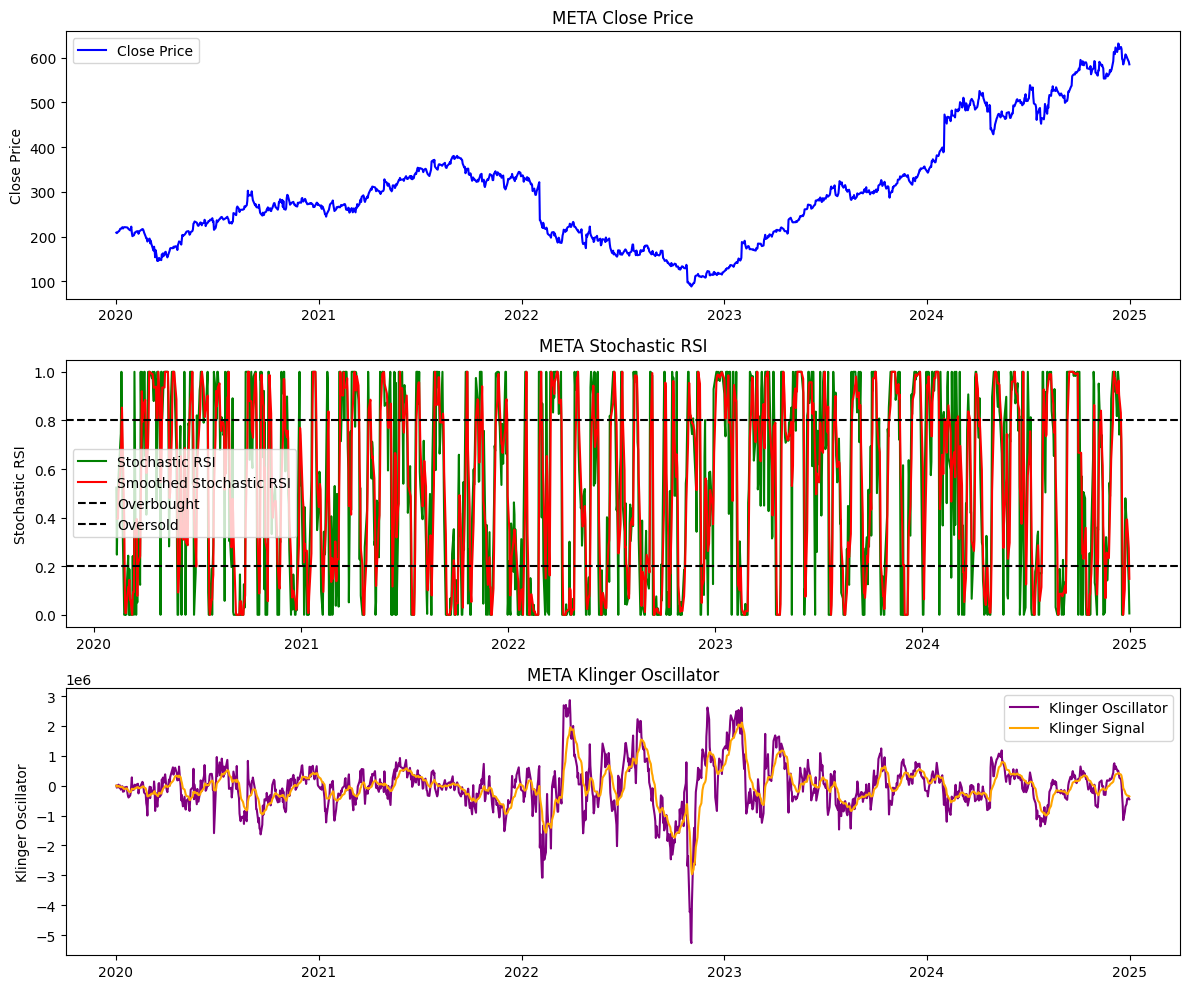

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate Stochastic RSI
def calculate_stochastic_rsi(df, period=14, smooth_period=3):
    rsi = df['Close'].rolling(window=period).apply(lambda x: 100 * (x[-1] - min(x)) / (max(x) - min(x)))
    stoch_rsi = (rsi - rsi.rolling(window=period).min()) / (rsi.rolling(window=period).max() - rsi.rolling(window=period).min())
    stoch_rsi_smooth = stoch_rsi.rolling(window=smooth_period).mean()
    return stoch_rsi, stoch_rsi_smooth

# Function to calculate Klinger Oscillator
def calculate_klinger_oscillator(df, short_period=34, long_period=55, signal_period=13):
    mfm = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mfv = mfm * df['Volume']
    short_ema = mfv.ewm(span=short_period).mean()
    long_ema = mfv.ewm(span=long_period).mean()
    klinger_oscillator = short_ema - long_ema
    klinger_signal = klinger_oscillator.ewm(span=signal_period).mean()
    return klinger_oscillator, klinger_signal

# Define the stock symbol and time period
symbol = 'META'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Stochastic RSI and Klinger Oscillator
stoch_rsi, stoch_rsi_smooth = calculate_stochastic_rsi(df)
klinger_oscillator, klinger_signal = calculate_klinger_oscillator(df)

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Plot the Close Price
ax[0].plot(df.index, df['Close'], label='Close Price', color='blue')
ax[0].set_title(f'{symbol} Close Price')
ax[0].set_ylabel('Close Price')
ax[0].legend()

# Plot the Stochastic RSI
ax[1].plot(df.index, stoch_rsi, label='Stochastic RSI', color='green')
ax[1].plot(df.index, stoch_rsi_smooth, label='Smoothed Stochastic RSI', color='red')
ax[1].axhline(0.8, color='black', linestyle='--', label='Overbought')
ax[1].axhline(0.2, color='black', linestyle='--', label='Oversold')
ax[1].set_title(f'{symbol} Stochastic RSI')
ax[1].set_ylabel('Stochastic RSI')
ax[1].legend()

# Plot the Klinger Oscillator
ax[2].plot(df.index, klinger_oscillator, label='Klinger Oscillator', color='purple')
ax[2].plot(df.index, klinger_signal, label='Klinger Signal', color='orange')
ax[2].set_title(f'{symbol} Klinger Oscillator')
ax[2].set_ylabel('Klinger Oscillator')
ax[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
